<a href="https://colab.research.google.com/github/emtruong2/csc422-spring2024/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries and Data

In [163]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [143]:
### NOTE: Change path to where your datasets are stored ###

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Get the directory path
dir = ('/content/drive/My Drive/Junior/Spring 2024/CSC 422/CSC 422 Project/Datasets/')

# Get the data
imported_train = pd.read_csv(dir + 'fraudTrain.csv')
imported_test = pd.read_csv(dir + 'fraudTest.csv')

original_train = pd.concat([imported_train, imported_test])
original_train.head(2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [144]:
# Set a seed for reproducibility
random_seed = 24
np.random.seed(random_seed)

# Preprocess Data

## Remove columns

In [145]:
columns = original_train.columns
columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [202]:
# Drop unused and PII columns
columns_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'first',  'last',
                        'gender', 'street', 'city', 'state', 'zip', 'lat', 'long',
                        'city_pop', 'job', 'dob', 'trans_num']
train = original_train.drop(columns_to_drop, axis=1)

from sklearn.preprocessing import MinMaxScaler

# Scale numeric features to 0-1. (X - Xmin) / (Xmax - Xmin)
numeric_columns = ['amt', 'unix_time','merch_lat', 'merch_long']
train[numeric_columns] = MinMaxScaler().fit_transform(train[numeric_columns])

train.head(2)

,cc_num,merchant,category,amt,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,0.000137,0.000000e+00,0.350307,0.848603,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,0.003670,4.116637e-07,0.621490,0.486209,0


## Split training and test data

In [203]:
from sklearn.model_selection import train_test_split

# Separate feature and target variables (only using numeric features here)
X = train.drop(columns=['is_fraud', 'category', 'cc_num', 'merchant'])
y = train['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=random_seed)

## Balance the training set

In [204]:
y_train.value_counts()

is_fraud
0    1474205
1       7710
Name: count, dtype: int64

In [205]:
y_test.value_counts()

is_fraud
0    368538
1      1941
Name: count, dtype: int64

In [206]:
from sklearn.utils import resample

# Get the number of fraudulent samples
n_samples = y_train.value_counts().get(1)

# Split the data by majority and minority class
train = X_train
train['is_fraud'] = y_train
train_majority = train[train['is_fraud'] == 0]
train_minority = train[train['is_fraud'] == 1]

# Downsample the majority (non-fraudulent) class to create a more balanced
# training dataset.
majority_downsampled = resample(train_majority, replace=False,
                                n_samples=n_samples, random_state=random_seed)
train_downsampled = pd.concat([majority_downsampled, train_minority])
X_train = train_downsampled.drop(columns=['is_fraud'])
y_train = train_downsampled['is_fraud']

y_train.value_counts()

is_fraud
0    7710
1    7710
Name: count, dtype: int64

# Process Data

## K-Nearest Neighbors (KNN)

In [212]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
k_range = range(1, 21)
param_grid = dict(n_neighbors=k_range)

# Find the best k with cross-validation
grid = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid.fit(X_train, y_train)

# Fit the model on the training data
best_k = grid.best_params_['n_neighbors']
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Predict on the test data
knn_pred = best_knn.predict(X_test)

# Evaluate the model
print(f'Best K: {best_k}')
print(f'Accuracy: {accuracy_score(y_test, knn_pred)}')
print(f'Precision: {precision_score(y_test, knn_pred)}')
print(f'Recall: {recall_score(y_test, knn_pred)}')
print(f'F1: {f1_score(y_test, knn_pred)}')

Best K: 1
Accuracy: 0.8116897314017799
Precision: 0.024229074889867842
Recall: 0.889747552807831
F1: 0.047173547849601885


## Decision Tree

Text(0, 0.5, 'Average Accuracy of 5-fold validation')

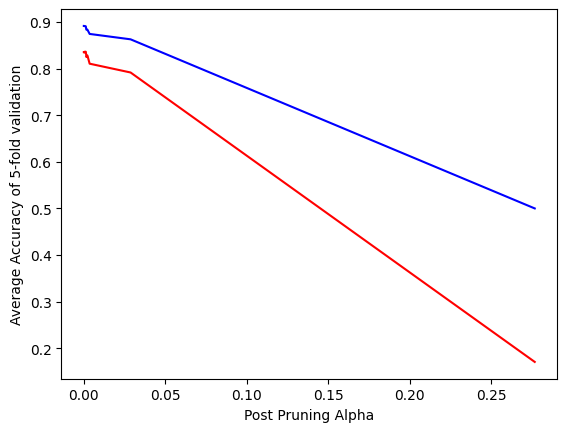

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=random_seed)
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

valid_accs = []
train_accs = []
best_valid_acc = 0
best_alpha = 0

for ccp_alpha in ccp_alphas:
  dt = DecisionTreeClassifier(criterion='gini', max_depth=5, ccp_alpha=ccp_alpha,
                            random_state=random_seed)

  k_fold_accs = cross_val_score(dt, X_train, y_train, cv=KFold(n_splits=5), scoring='accuracy')
  valid_acc = np.mean(k_fold_accs)

  dt.fit(X=X_train, y=y_train)
  train_acc = accuracy_score(y_train, dt.predict(X_train))

  valid_accs.append(valid_acc)
  train_accs.append(train_acc)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_alpha = ccp_alpha

plt.plot(ccp_alphas, valid_accs, color='red')
plt.plot(ccp_alphas, train_accs, color='blue')
plt.xlabel("Post Pruning Alpha")
plt.ylabel(f'Average Accuracy of 5-fold validation')

In [226]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, ccp_alpha=best_alpha,
                          random_state=random_seed)
dt.fit(X=X_train, y=y_train)
dt_pred = dt.predict(X_test)

# Evaluate the model
print(f'Best ccp alpha: {best_alpha}')
print(f'Accuracy: {accuracy_score(y_test, dt_pred)}')
print(f'Precision: {precision_score(y_test, dt_pred)}')
print(f'Recall: {recall_score(y_test, dt_pred)}')
print(f'F1: {f1_score(y_test, dt_pred)}')

Best ccp alpha: 0.0006412049146107025
Accuracy: 0.9213531671160848
Precision: 0.05387139107611549
Recall: 0.8459556929417826
F1: 0.10129237222787699


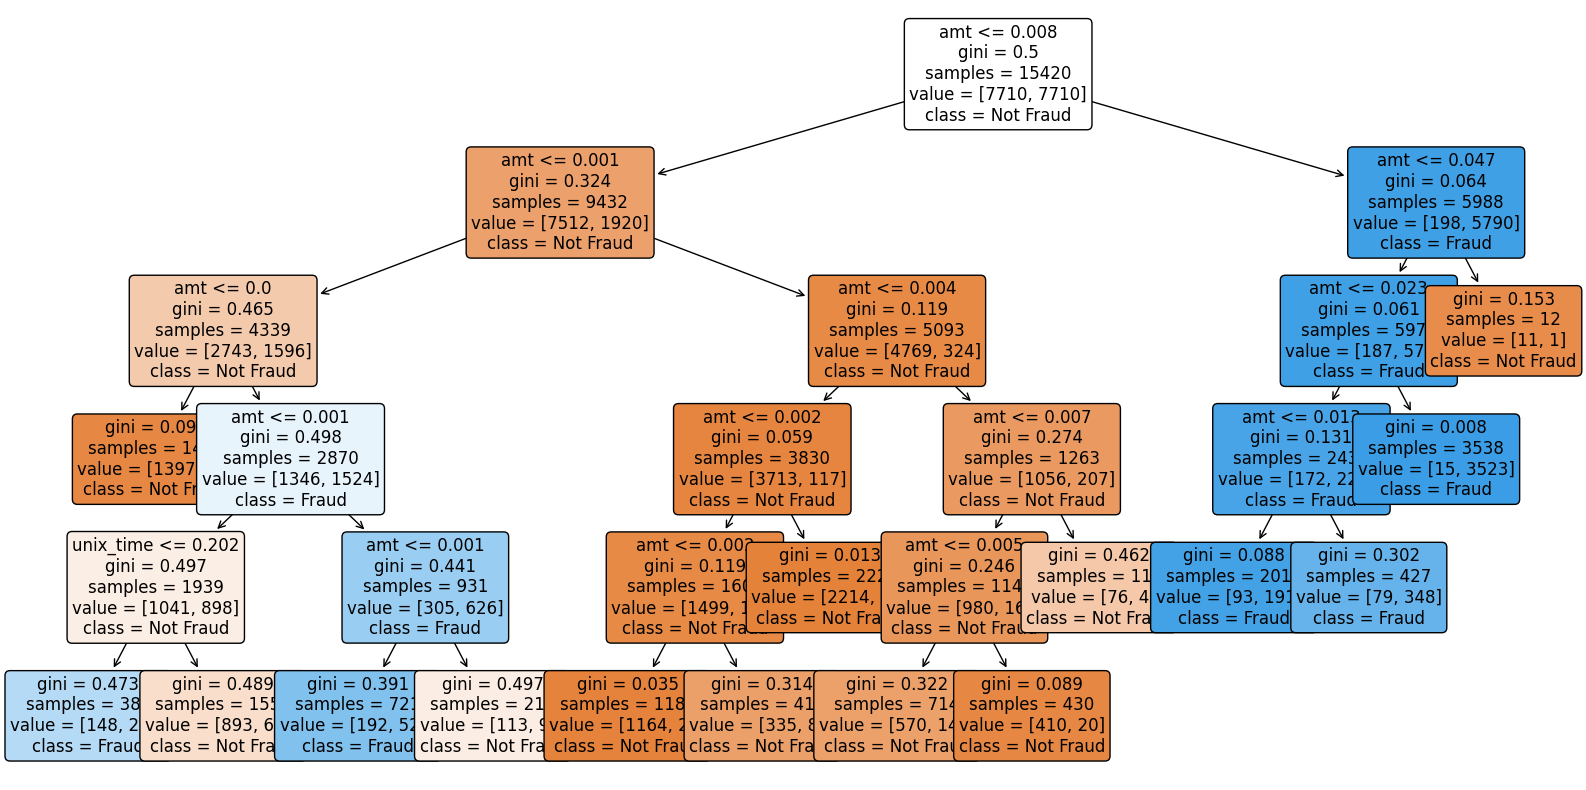

In [227]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
tree.plot_tree(dt, filled=True, feature_names=X_train.columns,
               class_names=['Not Fraud', 'Fraud'],
               rounded=True, fontsize=12)
plt.show()